In [119]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Perceptron
from sklearn.utils import shuffle
from sklearn.utils import resample
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

1.The AUC of the simple Perceptron class I defined with no activation function or hidden layers is 0.5824493173156656. To handle class imbalance I randomly drop some of the majority class which is data labeled nondiabetic. I start with random weight and bias parameters and during training I update them according to the learning rate of .5 I chose for 100 epochs. The predict method makes individual predictions while the prediction method returns a numpy array of predictions to calculate the AUROC.  This means it is not a good predictor because the false positive rate and true positive rate are similar and the model performs basically as well as random guess. 

0.5824493173156656


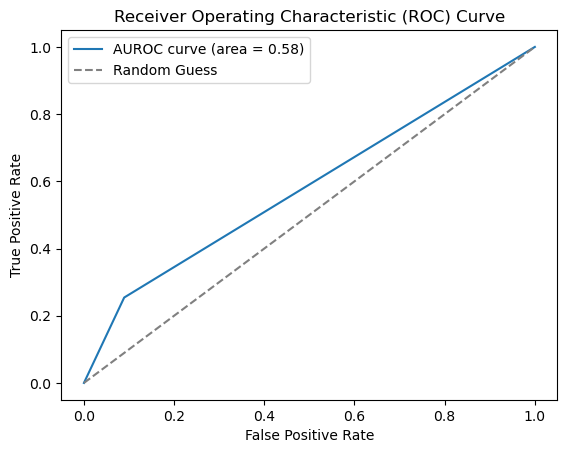

In [9]:
data=pd.read_csv('/Users/marieqi/Downloads/diabetes.csv')
df=data.dropna()
scaler=StandardScaler()
cols=['BMI', 'MentalHealth','PhysicalHealth', 'AgeBracket', 'EducationBracket', 'IncomeBracket', 'Zodiac']
majority_class=df[df['Diabetes']==0]
minority_class=df[df['Diabetes']==1]
num_samples_to_remove=len(majority_class)-len(minority_class)
majority_class_sampled=majority_class.sample(n=num_samples_to_remove,random_state=42)
data_balanced=df.drop(majority_class_sampled.index)
data_balanced=shuffle(data_balanced,random_state=42)
cols=['BMI', 'MentalHealth','PhysicalHealth', 'AgeBracket', 'EducationBracket', 'IncomeBracket', 'Zodiac']
data_balanced[cols]=scaler.fit_transform(data_balanced[cols])
df[cols]=scaler.fit_transform(df[cols])
X=data_balanced.iloc[:, 1:]
Y=data_balanced['Diabetes']
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=.2, random_state=42)
X_train, X_val, Y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
class Perceptron:
    def __init__(self):
        self.weight=None
        self.bias=None
    def predict(self,x):
        return np.dot(x,self.weight)+self.bias
    def train(self,x,y,lr=.5,epochs=100):
        self.weight=np.random.randn(x.shape[1])
        self.bias=np.random.randn()
        for i in range(len(x.iloc[:, 0])):
            input_vals=x.iloc[i]  
            label=y.iloc[i]              
            for _ in range(epochs):
                prediction=self.predict(input_vals)
                error=label-prediction
                self.weight+=lr*error*input_vals
                self.bias+=lr*error
    def prediction(self,x):
        predictions=np.zeros(len(x.iloc[:,0]))
        for i in range(len(x.iloc[:, 0])):
            predictions[i] = self.predict(x.iloc[i])
        return predictions


perceptron=Perceptron(tol=1e-3, random_state=0, shuffle=True)
perceptron.fit(X_train, Y_train)
predictions = perceptron.predict(X_test)
fpr,tpr,thresholds=roc_curve(Y_test, predictions)
roc_auc=roc_auc_score(Y_test, predictions)
print(roc_auc)
plt.plot(fpr, tpr, label=f'AUROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()    


2. First I modified he FC2Layer class to have random dropout after each activation to account for class imbalance. Then I made a copy of the class that does not take an activation function meaning there is no nonlinearity introduced in this version. I trained the data with a 2 epochs across all trials for consistency, and changed hidden layers and activation function to see the effect on AUROC. The AUC of the network with 2 hidden layers and Relu activation was 0.7419931317025428 which indiciates moderate performance. The network with 2 hidden layers and sigmoid activation was slightly worse at 0.7132804526236863, which shows relu and sigmoid did not produce a significant difference in accuracy. However sigmoid can cause vanishing gradients with more layers. With 8 hidden layers and sigmoid I get an AUROC of 0.6134508094275479 and we can see the loss values start to stagnate. Using one hidden layer and relu resulted in an AUC of 0.5, which is just random guess. Removing the hidden layers made the AUROC go to .5 which is just random guess, so AUROC score increases with hidden layers. Removing the activation function and using two hidden layers causes the AUROC to improve to  0.7869770661347899, which shows much greater ability to separate classes. Similarly using 1 hidden layer without activation makes AUROC go to 0.7810073551296752, compared to .5 with relu. This implies our data is linearly separable since each output is a linear combination of inputs in a network with no activation function.  

In [39]:
#modified code from lab6
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size, dropout_prob, activation):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.dropout_prob = dropout_prob
        if activation =='relu':
            self.activation = nn.ReLU()  
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else :
            self.activation = nn.ReLU()
            print("Activation function not implemented, using default ReLU")
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            self.activation,
            nn.Dropout(p=dropout_prob),
            nn.Linear(n_hidden, n_hidden), 
            self.activation,
            nn.Dropout(p=dropout_prob),
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = x.view(-1, self.input_size)      
        return self.network(x)
class FC2Layer2(nn.Module):
    def __init__(self, input_size, n_hidden, output_size, dropout_prob):
        super(FC2Layer2, self).__init__()
        self.input_size = input_size
        self.dropout_prob = dropout_prob
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.Dropout(p=dropout_prob),
            nn.Linear(n_hidden, n_hidden), 
            nn.Dropout(p=dropout_prob),
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = x.view(-1, self.input_size)      
        return self.network(x)
X=df.iloc[:, 1:]
Y=df['Diabetes']
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=.2, random_state=42)
X_train, X_val, Y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
def train(epoch, model, optimizer, perm=torch.arange(0, 21).long(), verbose=False):
        model.train()
        epoch_loss = 0
        losses = []
        criterion = nn.CrossEntropyLoss()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 21)
            data = data[:, perm]
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                losses.append(loss.detach())
                if verbose :
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))
                    
        return losses
def test(model, perm=torch.arange(0, 21).long(), verbose=False):
    model.eval()
    accuracy_list = []
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss(reduction='none')
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 21)
            data = data[:, perm]
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.sum().item()                                                      
            pred = output.data.max(1, keepdim=True)[1] 
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
        accuracy_list.append(accuracy) 
        if verbose :
            print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset),
                accuracy))
    return test_loss       
class CustomDataset(Dataset):
    def __init__(self, X,y):
        self.X_data = X
        self.y_data = y  
    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        X = torch.Tensor(self.X_data.iloc[idx].values)
        y = torch.LongTensor([self.y_data.iloc[idx]])
        return X, y.squeeze() 
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np
def calculate_auc(model, test_loader):
    model.eval()
    y_true=[]
    y_scores=[]
    with torch.no_grad():
        for data,target in test_loader:
            data,target = data.to(device),target.to(device)
            output=model(data)
            y_true.extend(target.cpu().numpy())
            y_scores.extend(output[:, 1].cpu().numpy())  
    return roc_auc_score(y_true, y_scores)
train_dataset = CustomDataset(X_train,Y_train)
test_dataset = CustomDataset(X_test,Y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=True)
input_size=21
output_size=2
n_hidden=2 
model_fnn=FC2Layer(input_size, n_hidden, output_size, .5, 'relu')
model_fnn=model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)

for epoch in range(0, 2):
    train(epoch, model_fnn, optimizer, verbose=True)
auc_score = calculate_auc(model_fnn, test_loader)
print("ROC AUC Score 2 hidden layers relu:", auc_score)
input_size=21
output_size=2
n_hidden=0 
model_fnn=FC2Layer(input_size, n_hidden, output_size, .5, 'relu')
model_fnn=model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)

for epoch in range(0, 2):
    train(epoch, model_fnn, optimizer, verbose=True)
auc_score = calculate_auc(model_fnn, test_loader)
print("ROC AUC Score 0 hidden layers relu:", auc_score)
input_size=21
output_size=2
n_hidden=2 
model_fnn=FC2Layer(input_size, n_hidden, output_size, .5, 'sigmoid')
model_fnn=model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)

for epoch in range(0, 2):
    train(epoch, model_fnn, optimizer, verbose=True)
auc_score = calculate_auc(model_fnn, test_loader)
print("ROC AUC Score 2 hidden layers sigmoid:", auc_score)
input_size=21
output_size=2
n_hidden=2 
model_fnn=FC2Layer2(input_size, n_hidden, output_size, .5)
model_fnn=model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)

for epoch in range(0, 2):
    train(epoch, model_fnn, optimizer, verbose=True)
auc_score = calculate_auc(model_fnn, test_loader)
print("ROC AUC Score 2 hidden layers no activation:", auc_score)
input_size=21
output_size=2
n_hidden=1 
model_fnn=FC2Layer(input_size, n_hidden, output_size, .5, 'relu')
model_fnn=model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)

for epoch in range(0, 2):
    train(epoch, model_fnn, optimizer, verbose=True)
auc_score = calculate_auc(model_fnn, test_loader)
print("ROC AUC Score 1 hidden layer relu:", auc_score)
input_size=21
output_size=2
n_hidden=1 
model_fnn=FC2Layer2(input_size, n_hidden, output_size, .5)
model_fnn=model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
for epoch in range(0, 2):
    train(epoch, model_fnn, optimizer, verbose=True)
auc_score = calculate_auc(model_fnn, test_loader)
print("ROC AUC Score 1 hidden layer no activation:", auc_score)

Number of parameters: 56
Train Epoch: 0 [0/162355 (0%)]	Loss: 0.608252
Train Epoch: 0 [6400/162355 (4%)]	Loss: 0.376455
Train Epoch: 0 [12800/162355 (8%)]	Loss: 0.358556
Train Epoch: 0 [19200/162355 (12%)]	Loss: 0.327205
Train Epoch: 0 [25600/162355 (16%)]	Loss: 0.441151
Train Epoch: 0 [32000/162355 (20%)]	Loss: 0.252408
Train Epoch: 0 [38400/162355 (24%)]	Loss: 0.403020
Train Epoch: 0 [44800/162355 (28%)]	Loss: 0.537543
Train Epoch: 0 [51200/162355 (32%)]	Loss: 0.318005
Train Epoch: 0 [57600/162355 (35%)]	Loss: 0.351042
Train Epoch: 0 [64000/162355 (39%)]	Loss: 0.714397
Train Epoch: 0 [70400/162355 (43%)]	Loss: 0.312230
Train Epoch: 0 [76800/162355 (47%)]	Loss: 0.261309
Train Epoch: 0 [83200/162355 (51%)]	Loss: 0.446146
Train Epoch: 0 [89600/162355 (55%)]	Loss: 0.403344
Train Epoch: 0 [96000/162355 (59%)]	Loss: 0.391180
Train Epoch: 0 [102400/162355 (63%)]	Loss: 0.496900
Train Epoch: 0 [108800/162355 (67%)]	Loss: 0.295991
Train Epoch: 0 [115200/162355 (71%)]	Loss: 0.390219
Train Epoch

/Users/marieqi/anaconda3/lib/python3.11/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Train Epoch: 0 [6400/162355 (4%)]	Loss: 0.550219
Train Epoch: 0 [12800/162355 (8%)]	Loss: 0.442375
Train Epoch: 0 [19200/162355 (12%)]	Loss: 0.483035
Train Epoch: 0 [25600/162355 (16%)]	Loss: 0.354554
Train Epoch: 0 [32000/162355 (20%)]	Loss: 0.352759
Train Epoch: 0 [38400/162355 (24%)]	Loss: 0.488867
Train Epoch: 0 [44800/162355 (28%)]	Loss: 0.378346
Train Epoch: 0 [51200/162355 (32%)]	Loss: 0.239219
Train Epoch: 0 [57600/162355 (35%)]	Loss: 0.434157
Train Epoch: 0 [64000/162355 (39%)]	Loss: 0.290893
Train Epoch: 0 [70400/162355 (43%)]	Loss: 0.463617
Train Epoch: 0 [76800/162355 (47%)]	Loss: 0.406128
Train Epoch: 0 [83200/162355 (51%)]	Loss: 0.320070
Train Epoch: 0 [89600/162355 (55%)]	Loss: 0.462992
Train Epoch: 0 [96000/162355 (59%)]	Loss: 0.320083
Train Epoch: 0 [102400/162355 (63%)]	Loss: 0.547848
Train Epoch: 0 [108800/162355 (67%)]	Loss: 0.520589
Train Epoch: 0 [115200/162355 (71%)]	Loss: 0.463184
Train Epoch: 0 [121600/162355 (75%)]	Loss: 0.491213
Train Epoch: 0 [128000/162355 

In [40]:
input_size=21
output_size=2
n_hidden=8 
model_fnn=FC2Layer(input_size, n_hidden, output_size, .5, 'sigmoid')
model_fnn=model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)

for epoch in range(0, 2):
    train(epoch, model_fnn, optimizer, verbose=True)
auc_score = calculate_auc(model_fnn, test_loader)
print("ROC AUC Score 8 hidden layers sigmoid:", auc_score)

Train Epoch: 0 [0/162355 (0%)]	Loss: 1.005408
Train Epoch: 0 [6400/162355 (4%)]	Loss: 0.397755
Train Epoch: 0 [12800/162355 (8%)]	Loss: 0.442692
Train Epoch: 0 [19200/162355 (12%)]	Loss: 0.520413
Train Epoch: 0 [25600/162355 (16%)]	Loss: 0.293806
Train Epoch: 0 [32000/162355 (20%)]	Loss: 0.240977
Train Epoch: 0 [38400/162355 (24%)]	Loss: 0.425977
Train Epoch: 0 [44800/162355 (28%)]	Loss: 0.359309
Train Epoch: 0 [51200/162355 (32%)]	Loss: 0.469069
Train Epoch: 0 [57600/162355 (35%)]	Loss: 0.479784
Train Epoch: 0 [64000/162355 (39%)]	Loss: 0.423252
Train Epoch: 0 [70400/162355 (43%)]	Loss: 0.352696
Train Epoch: 0 [76800/162355 (47%)]	Loss: 0.319812
Train Epoch: 0 [83200/162355 (51%)]	Loss: 0.312359
Train Epoch: 0 [89600/162355 (55%)]	Loss: 0.408188
Train Epoch: 0 [96000/162355 (59%)]	Loss: 0.362331
Train Epoch: 0 [102400/162355 (63%)]	Loss: 0.509366
Train Epoch: 0 [108800/162355 (67%)]	Loss: 0.439966
Train Epoch: 0 [115200/162355 (71%)]	Loss: 0.420936
Train Epoch: 0 [121600/162355 (75%)]

3.I defined a CNN class with two fully connected layers and three hidden layers, conv1, relu, and maxpooling and trained the dataset for two epochs. There is also an embedding layer to handle categorical data separately from continuous data, where categorical data like MentalHealth which takes values from 0 to 30 and Smoker which takes 0 or 1 are assigned a lower dimension vector, in this case a scalar since most categorical variables are binary, to help reduce dimensionality. Then I put these through conv1 which learns spatial patterns from the categorical data, which is why CNN is helpful for our dataset because many of these features are related like smoking and general health, and CNN's ability to distinguish feature hierarchy means these features can contribute to learning about specific aspects of data at different scales in convoluted layers. I then apply Relu to reduce complexity of the high dimension data, since there are 16 out channels, one for each feature with categorical data, and max pool to perform feature selection and dimensionality reduction to prevent overfitting. Then I concatenate the resulting embedded output matrix with the continuous data to put through the fully connected layers then the Relu activation which sets negative values to 0 and introduces some nonlinearity and further prepares the data for predictions in the softmax layer, which assigns the inputs a probability that results in our label. This model has an accuracy of 86.58% on the testloader data set, most likley due to the hyperparameter of out channels, I chose one for each in the embedding layer so that each feature then contributes independently to the output and the model may be able to learn more about specific feature influences but also creates risk of overfitting so I use dimensionality reduction to mitigate the effects. 

In [151]:
class CNN(nn.Module):
    def __init__(self, input_size, embedding_sizes, n_continuous, output_size):
        super(CNN, self).__init__()
        self.embedding_layers = nn.ModuleList([nn.Embedding(num_embeddings=16, embedding_dim=embedding_dim) for size, embedding_dim in embedding_sizes])
        self.conv1 = nn.Conv1d(in_channels=len(embedding_sizes), out_channels=16, kernel_size=1)
        self.fc1 = nn.Linear(16+n_continuous,64)
        self.fc2 = nn.Linear(64,output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x_cat, x_cont):
        embedded_outputs=[]
        for i in range(16):
            embedding_layer = self.embedding_layers[i]
            embedded_outputs.append(embedding_layer(x_cat[:, i].long()))
        embedded_outputs = [torch.tensor(embedded_output) for embedded_output in embedded_outputs]
        embedded_outputs = torch.stack(embedded_outputs, dim=1)
        embedded_outputs = embedded_outputs.unsqueeze(1)
        embedded_outputs = embedded_outputs.view(embedded_outputs.size(0), -1)
        embedded_outputs = embedded_outputs.transpose(0, 1)
        conv_out = self.conv1(embedded_outputs)
        conv_out = self.relu(conv_out)
        conv_out = torch.max_pool1d(conv_out, kernel_size=1)
        conv_out = conv_out.view(conv_out.size(0), -1) 
        conv_out=torch.transpose(conv_out, 0, 1)
        combined = torch.cat([conv_out, x_cont], dim=1)
        fc1_out = self.fc1(combined)
        fc1_out = self.relu(fc1_out)
        output = self.fc2(fc1_out)
        output = self.softmax(output)
        return output


data=pd.read_csv('/Users/marieqi/Downloads/diabetes.csv')
df=data.dropna()
scaler=StandardScaler()
cols=['BMI', 'MentalHealth','PhysicalHealth', 'AgeBracket', 'EducationBracket', 'IncomeBracket', 'Zodiac']
df[cols]=scaler.fit_transform(df[cols])
scaler= StandardScaler()
df_continuous=df[['BMI', 'AgeBracket', 'EducationBracket', 'IncomeBracket', 'Zodiac']].values
df_categorical= df[['HighBP','HighChol','Smoker','Stroke','Myocardial','PhysActivity','Fruit','Vegetables','HeavyDrinker','HasHealthcare','NotAbleToAffordDoctor','GeneralHealth','MentalHealth','PhysicalHealth','HardToClimbStairs','BiologicalSex']].values
df_categorical= torch.tensor(df_categorical, dtype=torch.long)
df_continuous= torch.tensor(scaler.fit_transform(df_continuous), dtype=torch.float32)
embedding_sizes=[(2, 1), (2, 1), (2, 1), (2, 1),(2, 1), (2, 1),(2, 1), (2, 1),(2, 1), (2, 1),(2, 1), (5, 1),(30,1),(30,1),(2, 1),(2, 1)]
input_size_continuous = df_continuous.shape[1]
output_size= 2 
model=CNN(input_size=len(embedding_sizes), embedding_sizes=embedding_sizes, n_continuous=input_size_continuous, output_size=output_size)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)
X_train_cat, X_test_cat, X_train_cont, X_test_cont, y_train, y_test = train_test_split(df_categorical, df_continuous, df['Diabetes'], test_size=0.2, random_state=42)
train_dataset=TensorDataset(X_train_cat, X_train_cont, torch.tensor(y_train.values))
test_dataset=TensorDataset(X_test_cat, X_test_cont, torch.tensor(y_test.values))
train_loader=DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=64, shuffle=False)
num_epochs=2
def train1(epoch, model, optimizer, train_loader, perm=torch.arange(0, 784).long(), verbose=False):
    model.train()
    epoch_loss=0
    losses=[]
    for batch_idx, (cat_data, cont_data, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs=model(cat_data,cont_data)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
        if batch_idx % 100 == 0:
            losses.append(loss.detach())
            if verbose:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,batch_idx*len(cat_data),len(train_loader.dataset),
                    100.*batch_idx/len(train_loader), loss.item()))
    epoch_loss /= len(train_loader.dataset)
    print('Epoch: {} Average loss: {:.4f}'.format(epoch, epoch_loss))
    return losses
for epoch in range(num_epochs):
    train_losses = train1(epoch, model, optimizer, train_loader, verbose=True)
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for cat_data, cont_data, labels in test_loader:
            outputs=model(cat_data, cont_data)
            _, predicted=torch.max(outputs.data, 1)
            total+=labels.size(0)
            correct+=(predicted == labels).sum().item()
    
    accuracy=correct/total
    print('Accuracy on test set: {:.2f}%'.format(100*accuracy))
    return accuracy
accuracy=evaluate(model, test_loader)

/var/folders/sw/z1pq8bn92ms8vtnzf3rkgfzh0000gn/T/ipykernel_85907/4164487157.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedded_outputs = [torch.tensor(embedded_output) for embedded_output in embedded_outputs]


Train Epoch: 0 [0/202944 (0%)]	Loss: 0.597890
Train Epoch: 0 [6400/202944 (3%)]	Loss: 0.286653
Train Epoch: 0 [12800/202944 (6%)]	Loss: 0.260705
Train Epoch: 0 [19200/202944 (9%)]	Loss: 0.334589
Train Epoch: 0 [25600/202944 (13%)]	Loss: 0.359837
Train Epoch: 0 [32000/202944 (16%)]	Loss: 0.361104
Train Epoch: 0 [38400/202944 (19%)]	Loss: 0.283162
Train Epoch: 0 [44800/202944 (22%)]	Loss: 0.380380
Train Epoch: 0 [51200/202944 (25%)]	Loss: 0.353416
Train Epoch: 0 [57600/202944 (28%)]	Loss: 0.355080
Train Epoch: 0 [64000/202944 (32%)]	Loss: 0.343141
Train Epoch: 0 [70400/202944 (35%)]	Loss: 0.418286
Train Epoch: 0 [76800/202944 (38%)]	Loss: 0.265704
Train Epoch: 0 [83200/202944 (41%)]	Loss: 0.349559
Train Epoch: 0 [89600/202944 (44%)]	Loss: 0.401909
Train Epoch: 0 [96000/202944 (47%)]	Loss: 0.235442
Train Epoch: 0 [102400/202944 (50%)]	Loss: 0.262743
Train Epoch: 0 [108800/202944 (54%)]	Loss: 0.245238
Train Epoch: 0 [115200/202944 (57%)]	Loss: 0.184266
Train Epoch: 0 [121600/202944 (60%)]	

4.The feedforward neural network with one hidden layer uses dropout to handle class imbalance and relu activation as for one hidden layer, this reduces dimensionality and creates network sparsity which helps aid convergence. First a fully connected layer uses linear transformation with weights and biases, adjusted with respect to a learning rate to prepare the data for prediction, then the activation function introduces non linearity and random dropout happens afterwards to help mitigate the effects of class imbalance. This repeats three times before the output is fed to the softmax function for prediction. The RMSE of the model is 34.4805 which means predictions were off by a very wide margin, however the range of the data is large, with the maximum being 97, and RMSE is sensitive to outliers so it may not be the most robust metric to evaluate the model. The RMSE of the model with sigmoid instead of RELU is 34.5014, which is almost exactly the same so RMSE does not depend on activation function.

In [198]:
data=pd.read_csv('/Users/marieqi/Downloads/diabetes.csv')
df=data.dropna()
scaler=StandardScaler()
Y=df['BMI']
X=df.drop(columns=['BMI'])
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=.2, random_state=42)
X_train, X_val, Y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
train_dataset=CustomDataset(X_train,Y_train)
test_dataset=CustomDataset(X_test,Y_test)
train_loader=DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=100, shuffle=True)
def train(epoch, model, optimizer, perm=torch.arange(0, 21).long(), verbose=False):
        model.train()
        epoch_loss = 0
        losses = []
        criterion = nn.CrossEntropyLoss()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 21)
            data = data[:, perm]
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                losses.append(loss.detach())
                if verbose :
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))
                    
        return losses
def calculate_rmse(model, test_loader):
    model.eval()  
    rmse=0.0
    total_samples=0
    with torch.no_grad():
        for inputs,targets in test_loader:
            outputs=model(inputs) 
            squared_diff=torch.pow(outputs-targets.unsqueeze(1), 2)
            mse=torch.mean(squared_diff)
            rmse+=torch.sqrt(mse)
            total_samples+=len(targets)
    rmse/=len(test_loader)
    return rmse
input_size=21
output_size=100
n_hidden=1 
model_fnn=FC2Layer(input_size, n_hidden, output_size, .5, 'relu')
model_fnn=model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
for epoch in range(0, 2):
    train(epoch, model_fnn, optimizer, verbose=True)
rmse=calculate_rmse(model_fnn,test_loader)
print('RMSE',rmse)
input_size=21
output_size=100
n_hidden=1 
model_fnn=FC2Layer(input_size, n_hidden, output_size, .5, 'sigmoid')
model_fnn=model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
for epoch in range(0, 2):
    train(epoch, model_fnn, optimizer, verbose=True)
rmse=calculate_rmse(model_fnn,test_loader)
print('RMSE',rmse)


Train Epoch: 0 [0/162355 (0%)]	Loss: 5.031344
Train Epoch: 0 [6400/162355 (4%)]	Loss: 4.878225
Train Epoch: 0 [12800/162355 (8%)]	Loss: 4.579885
Train Epoch: 0 [19200/162355 (12%)]	Loss: 4.563241
Train Epoch: 0 [25600/162355 (16%)]	Loss: 4.584604
Train Epoch: 0 [32000/162355 (20%)]	Loss: 4.380042
Train Epoch: 0 [38400/162355 (24%)]	Loss: 4.234180
Train Epoch: 0 [44800/162355 (28%)]	Loss: 4.202841
Train Epoch: 0 [51200/162355 (32%)]	Loss: 4.149135
Train Epoch: 0 [57600/162355 (35%)]	Loss: 4.102171
Train Epoch: 0 [64000/162355 (39%)]	Loss: 4.109626
Train Epoch: 0 [70400/162355 (43%)]	Loss: 4.018848
Train Epoch: 0 [76800/162355 (47%)]	Loss: 3.927942
Train Epoch: 0 [83200/162355 (51%)]	Loss: 3.902678
Train Epoch: 0 [89600/162355 (55%)]	Loss: 3.791308
Train Epoch: 0 [96000/162355 (59%)]	Loss: 3.745782
Train Epoch: 0 [102400/162355 (63%)]	Loss: 3.662572
Train Epoch: 0 [108800/162355 (67%)]	Loss: 3.818199
Train Epoch: 0 [115200/162355 (71%)]	Loss: 3.627409
Train Epoch: 0 [121600/162355 (75%)]

5. I used the same convolutional deep neural network as in question 3 to to predict BMI and I used iterative methods to tune the learning rate hyperparameter of the ADAM optimizer in lieu of grid search. I initialized an array of hyperparameters and trained the model on all of them, keeping all other parameters constant, to see the effect of learning rate on RMSE, through this I find that the best RMSE is 37.5484 with a learning rate parameter of .01, whereas .1 results in a slightly higher RMSE of 37.8679, and .5 results in a rmse of about 39. Learning rate of the ADAM optimizer I used is updated iteratively from a starting point. The algorithm uses gradient descent and adjusts the learning rate based on the mean and variance of the gradients therefore it is expected to converge to the optimal assuming it is not set too high that it overshoots or too low that convergence does not happen within the alotted iterations. Therfore ensuring parameters are updated with ideal step size minimizes RMSE by minimizing distance from predicted to actual points.  

In [191]:
class CNN(nn.Module):
    def __init__(self, input_size, embedding_sizes, n_continuous, output_size):
        super(CNN, self).__init__()
        self.embedding_layers = nn.ModuleList([nn.Embedding(num_embeddings=17, embedding_dim=embedding_dim) for size, embedding_dim in embedding_sizes])
        self.conv1 = nn.Conv1d(in_channels=11, out_channels=11, kernel_size=1)
        self.fc1 = nn.Linear(11+n_continuous,64)
        self.fc2 = nn.Linear(64,output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x_cat, x_cont):
        embedded_outputs=[]
        for i in range(11):
            embedding_layer = self.embedding_layers[i]
            embedded_outputs.append(embedding_layer(x_cat[:, i].long()))
        embedded_outputs = [torch.tensor(embedded_output) for embedded_output in embedded_outputs]
        embedded_outputs = torch.stack(embedded_outputs, dim=1)
        embedded_outputs = embedded_outputs.unsqueeze(1)
        embedded_outputs = embedded_outputs.view(embedded_outputs.size(0), -1)
        embedded_outputs = embedded_outputs.transpose(0, 1)
        conv_out = self.conv1(embedded_outputs)
        conv_out = self.relu(conv_out)
        conv_out = torch.max_pool1d(conv_out, kernel_size=1)
        conv_out = conv_out.view(conv_out.size(0), -1) 
        conv_out=torch.transpose(conv_out, 0, 1)
        combined = torch.cat([conv_out, x_cont], dim=1)
        fc1_out = self.fc1(combined)
        fc1_out = self.relu(fc1_out)
        output = self.fc2(fc1_out)
        output = self.softmax(output)
        return output


data=pd.read_csv('/Users/marieqi/Downloads/diabetes.csv')
df=data.dropna()
scaler= StandardScaler()
df_continuous=df[['AgeBracket', 'EducationBracket', 'IncomeBracket', 'Zodiac']].values
df_categorical= df[['Diabetes','HighBP','HighChol','Smoker','Stroke','Myocardial','PhysActivity','Fruit','Vegetables','HeavyDrinker','HasHealthcare','NotAbleToAffordDoctor','GeneralHealth','MentalHealth','PhysicalHealth','HardToClimbStairs','BiologicalSex']].values
df_categorical= torch.tensor(df_categorical, dtype=torch.long)
df_continuous= torch.tensor(scaler.fit_transform(df_continuous), dtype=torch.float32)
embedding_sizes=[(2, 1),(2, 1), (2, 1), (2, 1), (2, 1),(2, 1), (2, 1),(2, 1), (2, 1),(2, 1), (2, 1),(2, 1), (5, 1),(30,1),(30,1),(2, 1),(2, 1)]
input_size_continuous = df_continuous.shape[1]
output_size=100
model=CNN(input_size=len(embedding_sizes), embedding_sizes=embedding_sizes, n_continuous=input_size_continuous, output_size=output_size)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.1)
X_train_cat, X_test_cat, X_train_cont, X_test_cont, y_train, y_test = train_test_split(df_categorical, df_continuous, df['BMI'], test_size=0.2, random_state=42)
train_dataset=TensorDataset(X_train_cat, X_train_cont, torch.tensor(y_train.values))
test_dataset=TensorDataset(X_test_cat, X_test_cont, torch.tensor(y_test.values))
train_loader=DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=100, shuffle=False)
num_epochs=2
def train1(epoch, model, optimizer, train_loader, perm=torch.arange(0, 784).long(), verbose=False):
    model.train()
    epoch_loss=0
    losses=[]
    for batch_idx, (cat_data, cont_data, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs=model(cat_data,cont_data)
        labels=labels.long()
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
        if batch_idx % 100 == 0:
            losses.append(loss.detach())
            if verbose:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,batch_idx*len(cat_data),len(train_loader.dataset),
                    100.*batch_idx/len(train_loader), loss.item()))
    epoch_loss /= len(train_loader.dataset)
    print('Epoch: {} Average loss: {:.4f}'.format(epoch, epoch_loss))
    return losses
for epoch in range(num_epochs):
    train_losses = train1(epoch, model, optimizer, train_loader, verbose=True)
for cat_batch, cont_batch,labels_batch in test_loader:
    combined_batch = torch.cat((cat_batch, cont_batch), dim=1)
def calculate_rmse(model, test_loader):
    model.eval()  
    rmse=0.0
    total_samples=0
    with torch.no_grad():
        for cat_batch, cont_batch, labels_batch in test_loader:
            combined_batch = torch.cat((cat_batch, cont_batch), dim=1)
            outputs = model(cat_batch,cont_batch)
            squared_diff = torch.pow(outputs - labels_batch.unsqueeze(1), 2)
            mse = torch.mean(squared_diff)
            rmse += torch.sqrt(mse)
            total_samples += len(labels_batch)
    rmse /= len(test_loader)
    return rmse
rmse=calculate_rmse(model,test_loader)
print('RMSE',rmse) 

/var/folders/sw/z1pq8bn92ms8vtnzf3rkgfzh0000gn/T/ipykernel_85907/873824480.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedded_outputs = [torch.tensor(embedded_output) for embedded_output in embedded_outputs]


Train Epoch: 0 [0/202944 (0%)]	Loss: 4.677636
Train Epoch: 0 [10000/202944 (5%)]	Loss: 3.158914
Train Epoch: 0 [20000/202944 (10%)]	Loss: 3.071005
Train Epoch: 0 [30000/202944 (15%)]	Loss: 3.044076
Train Epoch: 0 [40000/202944 (20%)]	Loss: 3.120671
Train Epoch: 0 [50000/202944 (25%)]	Loss: 3.089694
Train Epoch: 0 [60000/202944 (30%)]	Loss: 3.068555
Train Epoch: 0 [70000/202944 (34%)]	Loss: 3.183105
Train Epoch: 0 [80000/202944 (39%)]	Loss: 3.025813
Train Epoch: 0 [90000/202944 (44%)]	Loss: 3.203900
Train Epoch: 0 [100000/202944 (49%)]	Loss: 3.072562
Train Epoch: 0 [110000/202944 (54%)]	Loss: 3.044748
Train Epoch: 0 [120000/202944 (59%)]	Loss: 3.198979
Train Epoch: 0 [130000/202944 (64%)]	Loss: 3.078929
Train Epoch: 0 [140000/202944 (69%)]	Loss: 3.281534
Train Epoch: 0 [150000/202944 (74%)]	Loss: 3.067777
Train Epoch: 0 [160000/202944 (79%)]	Loss: 2.976465
Train Epoch: 0 [170000/202944 (84%)]	Loss: 3.336936
Train Epoch: 0 [180000/202944 (89%)]	Loss: 3.124246
Train Epoch: 0 [190000/20294

In [197]:
learning_rates = [0.01, 0.05, 0.1, 0.5, 1.0]
best_rmse = float('inf')
ler=0
for lr in learning_rates:
    
    for epoch in range(2):
        embedding_sizes=[(2, 1),(2, 1), (2, 1), (2, 1), (2, 1),(2, 1), (2, 1),(2, 1), (2, 1),(2, 1), (2, 1),(2, 1), (5, 1),(30,1),(30,1),(2, 1),(2, 1)]
        input_size_continuous = df_continuous.shape[1]
        output_size=100
        model=CNN(input_size=len(embedding_sizes), embedding_sizes=embedding_sizes, n_continuous=input_size_continuous, output_size=output_size)
        criterion=nn.CrossEntropyLoss()
        optimizer=optim.Adam(model.parameters(), lr=lr)
        train_losses = train1(epoch, model, optimizer, train_loader, verbose=True)    
        model.eval()
        rmse=calculate_rmse(model,test_loader)
        if rmse<best_rmse:
            best_rmse=rmse
            ler=lr
print('best lr:',ler)
print('best rmse:',best_rmse)

/var/folders/sw/z1pq8bn92ms8vtnzf3rkgfzh0000gn/T/ipykernel_85907/873824480.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedded_outputs = [torch.tensor(embedded_output) for embedded_output in embedded_outputs]


Train Epoch: 0 [0/202944 (0%)]	Loss: 4.637815
Train Epoch: 0 [10000/202944 (5%)]	Loss: 3.065700
Train Epoch: 0 [20000/202944 (10%)]	Loss: 3.093155
Train Epoch: 0 [30000/202944 (15%)]	Loss: 3.010359
Train Epoch: 0 [40000/202944 (20%)]	Loss: 3.181977
Train Epoch: 0 [50000/202944 (25%)]	Loss: 3.034553
Train Epoch: 0 [60000/202944 (30%)]	Loss: 2.972929
Train Epoch: 0 [70000/202944 (34%)]	Loss: 3.069749
Train Epoch: 0 [80000/202944 (39%)]	Loss: 3.004210
Train Epoch: 0 [90000/202944 (44%)]	Loss: 3.112868
Train Epoch: 0 [100000/202944 (49%)]	Loss: 2.932541
Train Epoch: 0 [110000/202944 (54%)]	Loss: 3.179209
Train Epoch: 0 [120000/202944 (59%)]	Loss: 3.032987
Train Epoch: 0 [130000/202944 (64%)]	Loss: 3.014752
Train Epoch: 0 [140000/202944 (69%)]	Loss: 2.952281
Train Epoch: 0 [150000/202944 (74%)]	Loss: 3.094878
Train Epoch: 0 [160000/202944 (79%)]	Loss: 2.975713
Train Epoch: 0 [170000/202944 (84%)]	Loss: 3.264859
Train Epoch: 0 [180000/202944 (89%)]	Loss: 3.191909
Train Epoch: 0 [190000/20294